<a href="https://colab.research.google.com/github/ADI201998/sparse-to-depth-GAN/blob/master/depth_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 377.0MB 96kB/s 


In [0]:
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import os
import h5py
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers import ZeroPadding2D, Activation, BatchNormalization, MaxPooling2D, Dense, Add, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input, Dropout
from keras import losses
from keras.optimizers import Adam
from keras.utils import to_categorical

input_shape_generator = (480, 640, 4)
input_shape_discriminator = (480, 640, 1)

Using TensorFlow backend.


In [0]:
def dense_to_sparse(rgb, depth):
        """
        Samples pixels with `num_samples`/#pixels probability in `depth`.
        Only pixels with a maximum depth of `max_depth` are considered.
        If no `max_depth` is given, samples in all pixels
        """
        # max depth is np.inf
        mask_keep = depth > 0
        if np.inf is not np.inf:
                mask_keep = np.bitwise_and(mask_keep, depth <= 1.0)
        n_keep = np.count_nonzero(mask_keep)
        if n_keep == 0:
                return mask_keep
        else:
                prob = float(200) / n_keep
                return np.bitwise_and(mask_keep, np.random.uniform(0, 1, depth.shape) < prob)

In [0]:
def create_sparse_depth(rgb, depth):
        mask_keep = dense_to_sparse(rgb, depth)
        sparse_depth = np.zeros(depth.shape)
        sparse_depth[mask_keep] = depth[mask_keep]
        return sparse_depth

In [0]:
def create_rgbd(rgb, depth):
        sparse_depth = create_sparse_depth(rgb, depth)
        rgbd = np.append(rgb, np.expand_dims(sparse_depth, axis=2), axis=2)
        rgbd = rgbd[np.newaxis, :, :, :]
        return rgbd

In [0]:
def dataset():
        X_train = np.empty((1400, 480, 640, 4))
        Y_train = np.empty((1400, 480, 640, 1))
        X_test = np.empty((280, 480, 640, 4))
        Y_test = np.empty((280, 480, 640, 1))
        rootdir_train = '/content/drive/My Drive/Dataset/train/'
        rootdir_val = '/content/drive/My Drive/Dataset/val/official/'
        print("TRAIN")
        j = i = 0
        for subdir, dirs, files in sorted(os.walk(rootdir_train)):
                print(j)
                files = sorted(files)
                print(len(files))
                if len(files) != 0:
                        for k in range(5):
                              #print(i)
                              path = subdir + '/' + files[k]
                              h5f = h5py.File(path, "r")
                              rgb = np.array(h5f['rgb'])
                              rgb = np.transpose(rgb, (1, 2, 0))
                              depth = np.array(h5f['depth'])
                              depth  = depth /9
                              #cv2.imshow("rgb", rgb)
                              #cv2.imshow("depth", depth)
                              X_train[i] = create_rgbd(rgb, depth)
                              Y_train[i] = depth[:, :, np.newaxis]
                              i = i+1
                              #cv2.waitKey(0)
                              #cv2.destroyAllWindows()
                        j = j+1
                                                
        print("TEST")
        for subdir, dirs, files in sorted(os.walk(rootdir_val)):
                files = sorted(files)
                print(len(files))
                for i in range(280):
                        print(i)
                        path = subdir + '/' + files[i]
                        h5f = h5py.File(path, "r")
                        rgb = np.array(h5f['rgb'])
                        rgb = np.transpose(rgb, (1, 2, 0))
                        depth = np.array(h5f['depth'])
                        depth  = depth /9
                        X_test[i] = create_rgbd(rgb, depth)
                        Y_test[i] = depth[:, :, np.newaxis]
        print("OVER")
        print("Done")
        return X_train, Y_train, X_test, Y_test

In [0]:
def generator_model():
    #encoder
    X_input = Input(input_shape_generator)
    X = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Conv2D(256, 3,activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Conv2D(256, 1, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X1 = X
    X = Conv2D(512, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Conv2D(512, 1, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X2 = X
    X = Conv2D(512, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X3 = X 
    X = Conv2D(512, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((1,2))(X)

    #decoder
    X = Conv2D(512, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(UpSampling2D((1,2))(X))
    X = BatchNormalization(axis=3)(X)
    X = Add()([X,X3])
    X = Dropout(0.5)(X)

    X = Conv2D(512, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(UpSampling2D((2,2))(X))
    X = BatchNormalization(axis=3)(X)
    X = Add()([X,X2])

    X = Conv2D(256, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(UpSampling2D((2,2))(X))
    X = BatchNormalization(axis=3)(X)
    X = Add()([X,X1])
    X = Dropout(0.5)(X)

    X = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(UpSampling2D((2,2))(X))
    X = BatchNormalization(axis=3)(X)
    X = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(UpSampling2D((2,2))(X))
    X = BatchNormalization(axis=3)(X)
    X = Dropout(0.5)(X)
    X = Conv2D(1, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(UpSampling2D((2,2))(X))
    X_out = BatchNormalization(axis=3)(X)

    model = Model(input = X_input, output = X_out, name='Generator')
    return model

In [0]:
 def discriminator_model():
    X_input = Input(input_shape_discriminator)
    X = Conv2D(64, kernel_size=(3,3), activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Conv2D(128, kernel_size=(3,3), activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Conv2D(256, kernel_size=(3,3), activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Conv2D(512, kernel_size=(3,3), activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Conv2D(1024, kernel_size=(3,3), activation = 'relu', padding='same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Flatten()(X)
    X_out = Dense(1, activation = 'sigmoid')(X)

    model = Model(input =  X_input, output = X_out, name='Discriminator')
    return model

In [0]:
def gan_model(generator, discriminator):
    gan_input = Input(input_shape_generator)
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(input = gan_input, output = [x, gan_output], name='GAN')
    return gan

----------------------GETTING INPUTS-----------------------
TRAIN
0
0
0
20
1
20
2
20
3
20
4
20
5
20
6
20
7
20
8
20
9
20
10
20
11
20
12
20
13
20
14
20
15
20
16
20
17
20
18
20
19
20
20
20
21
20
22
20
23
20
24
20
25
20
26
20
27
20
28
20
29
20
30
20
31
20
32
20
33
20
34
20
35
20
36
20
37
20
38
20
39
20
40
20
41
20
42
20
43
20
44
20
45
20
46
20
47
20
48
20
49
20
50
20
51
20
52
20
53
11
54
20
55
20
56
20
57
20
58
20
59
20
60
20
61
20
62
20
63
20
64
20
65
20
66
20
67
20
68
20
69
20
70
20
71
20
72
20
73
20
74
20
75
20
76
20
77
20
78
20
79
20
80
20
81
20
82
20
83
20
84
20
85
20
86
20
87
20
88
20
89
20
90
20
91
20
92
20
93
20
94
20
95
20
96
20
97
20
98
20
99
20
100
20
101
20
102
20
103
20
104
20
105
20
106
20
107
20
108
20
109
20
110
20
111
20
112
20
113
20
114
20
115
20
116
20
117
20
118
20
119
20
120
20
121
20
122
20
123
20
124
20
125
20
126
20
127
20
128
20
129
20
130
20
131
20
132
20
133
20
134
20
135
20
136
20
137
20
138
20
139
20
140
20
141
20
142
20
143
20
144
22
145
20
146
20
147
20
148


W0815 16:19:31.705237 140622130927488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 16:19:31.771388 140622130927488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 16:19:31.783904 140622130927488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0815 16:19:31.809412 140622130927488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0815 16:19:31.810466

279
OVER
Done
(1400, 480, 640, 4) (1400, 480, 640, 1) (280, 480, 640, 4) (280, 480, 640, 1)
----------------------INITIALIZING MODELS-----------------------


W0815 16:19:34.949231 140622130927488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0815 16:19:35.025262 140622130927488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0815 16:19:35.704842 140622130927488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0815 16:19:35.794645 140622130927488 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed 

----------------------COMPILING MODELS-----------------------
----------------------STARTING TRAINING-----------------------
Epochs :  0  D_loss :  [8.3680105 0.3      ]  G_loss :  [797.48804, 0.7982863, 1.1920933e-07]
Epochs :  1  D_loss :  [7.9711924 0.5      ]  G_loss :  [708.6973, 0.70940673, 1.1920933e-07]
Epochs :  2  D_loss :  [7.9711924 0.5      ]  G_loss :  [596.3638, 0.5969607, 1.1920933e-07]
Epochs :  3  D_loss :  [7.9711924 0.5      ]  G_loss :  [542.35175, 0.54289466, 1.1920933e-07]
Epochs :  4  D_loss :  [7.9711924 0.5      ]  G_loss :  [466.17194, 0.46663857, 1.1920933e-07]
Epochs :  5  D_loss :  [7.9711924 0.5      ]  G_loss :  [415.04416, 0.41545963, 1.1920933e-07]
Epochs :  6  D_loss :  [7.9711924 0.5      ]  G_loss :  [414.0516, 0.41446608, 1.1920933e-07]
Epochs :  7  D_loss :  [7.9711924 0.5      ]  G_loss :  [422.00174, 0.42242417, 1.1920933e-07]
Epochs :  8  D_loss :  [7.9711924 0.5      ]  G_loss :  [403.77985, 0.40418404, 1.1920933e-07]
Epochs :  9  D_loss :  [7

W0815 16:26:07.083679 140622130927488 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(480, 640, 3)
(480, 640, 1)
(480, 640, 1)


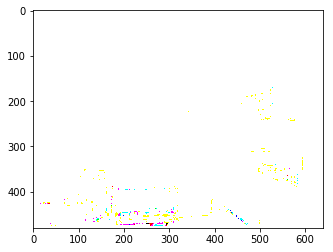

TypeError: ignored

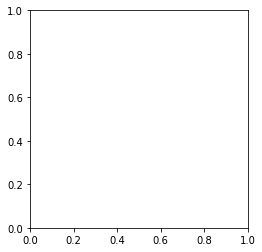

In [0]:
batch_size = 10
epochs = 140
input_shape = (480, 640, 4)
# 280 x 20 
##  INPUT  ##
print("----------------------GETTING INPUTS-----------------------")
X_train, Y_train, X_test, Y_test = dataset()
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

## INITIALIZE MODELS  ##
print("----------------------INITIALIZING MODELS-----------------------")
generator = generator_model()       
discriminator = discriminator_model()
gan = gan_model(generator, discriminator)

## COMPILE MODELS ##
print("----------------------COMPILING MODELS-----------------------")
discriminator.trainable = True
discriminator.compile(optimizer = Adam(4e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
discriminator.trainable = False
gan.compile(optimizer = Adam(4e-4), loss = ['mae', 'binary_crossentropy'], loss_weights=[1, 0.001])
discriminator.trainable = True

print("----------------------STARTING TRAINING-----------------------")

for epoch in range(epochs):
    # SELECTING RANDOM BATCH OF IMAGES                      
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    op_imgs = Y_train[idx]

    # GENERATE NEW IMAGES
    generated_img = generator.predict(imgs)

    # TRAIN DISCRIMINATOR
    d_loss_real = discriminator.train_on_batch(op_imgs, valid)
    d_loss_fake = discriminator.train_on_batch(generated_img, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    discriminator.trainable = False
    # TRAIN GENERATOR
    g_loss = gan.train_on_batch(imgs, [op_imgs, valid])                           #fill 
    
    print("Epochs : ",epoch," D_loss : ", d_loss, " G_loss : ", g_loss)
    discriminator.trainable = True

print("----------------------TRAINING ENDS-----------------------")
generator.save('generator_model.h5')
discriminator.save('disriminator_model.h5')
predicted_imgs = generator.predict(X_test)
for i in range(20):
    #rgb = np.squeeze(X_test[i], axis=0)
    rgb = X_test[i, :, :, 0:3]
    print(rgb.shape)
    depth = Y_test[i, :, :, :]
    print(depth.shape)
    depth_pred = predicted_imgs[i, :, :, :]
    print(depth_pred.shape)
    plt.imshow(rgb)
    plt.show()
    #cv2_imshow(str(i)+"rgb", rgb)
    #depth = np.squeeze(Y_test[i], axis=0)
    
    #cv2_imshow(str(i)+"depth", depth)
    plt.imshow(depth)
    plt.show()
    #depth_pred = np.squeeze(generated_img[i], axis=0)
    #cv2_imshow(str(i)+"depth_pred", depth_pred)
    plt.imshow(depth_pred)
    plt.show()
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()